# 2.4.1 理解CNN

#### 一. 什么是CNN
1. 简单来说, CNN就是在矩阵上进行的滑动窗口方法
<img src='img/Convolution_schematic.gif' height='40%' width='40%'>
2. 卷积运算为什能执行边缘检测  
[http://colah.github.io/posts/2014-07-Understanding-Convolutions/](http://colah.github.io/posts/2014-07-Understanding-Convolutions/) 

#### 二. Conv1D
[http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

#### 三. keras中的1d-CNN
1. keras中, 使用`Conv1D`层  
 Conv1D定义为(filters, kernel_size)
 输入 : 3D张量 (samples, time_step, features)  
 输出 : 同样结构的3D张量 (samples, newstep, new_features)   
 其中, newstep = time_step-kernel_size+1, new_features=filters
 `Conv1D(filters, kernel_size)` 
2. CNN卷积核的大小
  1. CNN卷积核的大小为$step\_num * feature\_num$, 其中$step\_num$对应时间步维度, 也叫作CNN窗口    
  2. CNN卷积核上, 同一行的所有位置的数字相同. 所以1DConvNet大大减小了计算量, 大小为7的CNN窗口, 只有7个未知参数
3. keras中的1D-卷积网络
  1. 1D卷积网络, 由`Conv1D`层和`MaxPooling1D`层组成  
    1. `Conv1D(filters, kernel_size)`  
    2. `MaxPooling1D(self, pool_size=)`
  2. 然后使用`Flatten`或`GlobalMaxPooling`层, 将卷积网络的3D输出转换为2D输出, 这样就可以叠加更多的全连接层进行分类或回归  
    `GlobalMaxPooling1D`的输入为3D张量(batch_size, steps, features), 输出位2D张量(batch_size, features). 在整个矩阵上选出最大值
  2. 如下,展示了1DConvNet处理电影数据集情感分类问题

In [15]:
# 1. 数据预处理
from keras.models import Sequential
from keras.layers import Conv1D,Embedding,MaxPooling1D,GlobalAveragePooling1D,Dense
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500
print 'load data'
(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=max_features)
print 'Pad Sequence samples'
x_train = sequence.pad_sequences(x_train,maxlen=max_len)
x_test = sequence.pad_sequences(x_test,maxlen=max_len)
print 'x_train shape: %s, x_test shape %s' % (x_train.shape,x_test.shape)

load data
Pad Sequence samples
x_train shape: (25000, 500), x_test shape (25000, 500)


In [16]:
# 2.搭建网络
from keras import layers
model = Sequential()
# Embedding(dictionary_len,wordfeature_num, sentence_len)
model.add(layers.Embedding(max_features,128,input_length=max_len))  
# Conv1D(filters,kernel_size)
model.add(layers.Conv1D(32,7,activation='relu'))
# MaxPool1D(pool_size)
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.GlobalMaxPool1D())
# Dense(units)
model.add(Dense(1,activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.fit(x_train,y_train,batch_size=32,epochs=10,validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 9s 464us/step - loss: 0.4399 - acc: 0.7796 - val_loss: 0.2974 - val_acc: 0.8768
Epoch 2/10
20000/20000 [==============================] - 5s 258us/step - loss: 0.2455 - acc: 0.9030 - val_loss: 0.2764 - val_acc: 0.8868
Epoch 3/10
20000/20000 [==============================] - 5s 273us/step - loss: 0.1757 - acc: 0.9315 - val_loss: 0.3163 - val_acc: 0.8778
Epoch 4/10
20000/20000 [==============================] - 5s 263us/step - loss: 0.1198 - acc: 0.9570 - val_loss: 0.2946 - val_acc: 0.8896
Epoch 5/10
20000/20000 [==============================] - 5s 267us/step - loss: 0.0691 - acc: 0.9777 - val_loss: 0.3529 - val_acc: 0.8896
Epoch 6/10
20000/20000 [==============================] - 6s 282us/step - loss: 0.0346 - acc: 0.9901 - val_loss: 0.3888 - val_acc: 0.8806
Epoch 7/10
20000/20000 [==============================] - 6s 278us/step - loss: 0.0133 - acc: 0.9966 - val_loss: 0.4849 - v

### 2.4.2 组合CNN和RNN处理长时间序列

#### 一. 1D convnet的特点
1. 1D-convnet独立的处理输入块(以卷积窗口大小划分输入块), 将改时间步内所有的feature计算卷积后输出一个数值.因此:  
  1. 1d-convnet不能理解输入时间步的顺序  
  2. 1D-convnet根据filter_numbers, 缩减长时间步输入为1维的短序列输出向量 
  3. 1D-convnet的计算简单, 训练速度很快  
2. RNN的方法能理解输入语句的单词顺序, 但训练时间太长. 因此,尝试组合conv1d和rnn的方法来解决序列问题  
  1. 对于长序列输入, 使用1dconvnet作为RNN网络的预处理: 使用1D-convnet减小输入序列长度  
  2. 天气预测问题, 使用RNN解决时, lookback=10天, 统计步长account_step=6为1小时.现在组合1dCNN后, 可增加输入序列的长度. 设置account_step=3为半小时, 输入序列长度增加一倍 
  
[总结]:   
 如果输入数据的全局顺序,与要解决问题的无关,部分输入块的顺序与解决的问题有关, 则可以考虑使用1d卷积.  
 1d卷积结果在这种情况下同样很好,而且计算速度快很多

In [1]:
#### 1. 读取数据
import os
import pandas as pd
import numpy as np
data_dir = '/home/lj/data/Deelearning_with_python'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')
data = pd.read_csv(fname,index_col='Date Time')
### ２. 正则化数据
test_data = data[:200000]
float_data = test_data.values.astype(np.float64)
print float_data[0,:]
mean = float_data.mean(axis=0)
float_data -= mean
std = float_data.std(axis=0)
float_data /= std
print float_data.shape
# 3. 生成Generator对象
lookback = 10*24*6  # 10天
delay = 1*24*6      # 1天
account_step = 3    # 统计步长半小时
def generator(data,min_index,max_index,shuffle=False,batch_size=32,lookback=lookback,delay=delay,account_step=account_step):
    while 1 : 
            if shuffle:
                start_samples  = np.random.randint(min_index , max_index-lookback, size=batch_size)
            else : 
                start_samples = np.arange(min_index, min_index+account_step*batch_size, account_step)

            samples = np.zeros((batch_size, lookback//account_step, data.shape[-1]))
            targets = np.zeros(batch_size)
            
            # [注] : 列表在进行enumerate后, 才能变成(index,value)的键值对集合
            for i,sample_start in enumerate(start_samples):
                time_steps = range(sample_start, sample_start+lookback, account_step)
                samples[i] = float_data[time_steps,:]
                targets[i] = float_data[time_steps[-1] + delay,1]

            yield samples,targets

[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]
(200000, 14)


In [2]:
train_gen = generator(float_data,min_index=0,max_index=100000,shuffle=True)
val_gen = generator(float_data,min_index=100001,max_index=105000,shuffle=True)
test_gen = generator(float_data,min_index=105001,max_index=110000,shuffle=True)

val_step = 105000 -100001- lookback
test_steps = 110000 - 105001 - lookback
print val_step,test_steps

3559 3559


In [7]:
from keras import layers,models
model = models.Sequential()
model.add(layers.Conv1D(32,5,input_shape=(None,float_data.shape[-1]),activation='relu'))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='rmsprop',loss='mae')
history = model.fit_generator(train_gen,
                   steps_per_epoch = 500,  # 生成器返回多少次算是一个epoch
                   epochs=10,      # epoch数
                   validation_data = val_gen,  #  验证集生成器
                   validation_steps = val_step)

Epoch 1/10
500/500 [==============================] - 198s 396ms/step - loss: 0.3364 - val_loss: 0.4505
Epoch 2/10
500/500 [==============================] - 197s 394ms/step - loss: 0.2993 - val_loss: 0.3568
Epoch 3/10
500/500 [==============================] - 206s 412ms/step - loss: 0.2906 - val_loss: 0.3464
Epoch 4/10
500/500 [==============================] - 200s 400ms/step - loss: 0.2796 - val_loss: 0.3994
Epoch 5/10
500/500 [==============================] - 189s 377ms/step - loss: 0.2722 - val_loss: 0.3715
Epoch 6/10
500/500 [==============================] - 189s 378ms/step - loss: 0.2690 - val_loss: 0.3350
Epoch 7/10
500/500 [==============================] - 189s 378ms/step - loss: 0.2638 - val_loss: 0.3461
Epoch 8/10
500/500 [==============================] - 188s 377ms/step - loss: 0.2565 - val_loss: 0.3431
Epoch 9/10
500/500 [==============================] - 198s 396ms/step - loss: 0.2521 - val_loss: 0.3381
Epoch 10/10
500/500 [==============================] - 191s 382m

In [12]:
history.history['val_loss']

[0.4505484279419941,
 0.3568498820786598,
 0.34638724007794747,
 0.3993590729738695,
 0.37147193903013975,
 0.33502504332543226,
 0.3460616089171257,
 0.34305315530259944,
 0.33809199688072183,
 0.3818848146610831]

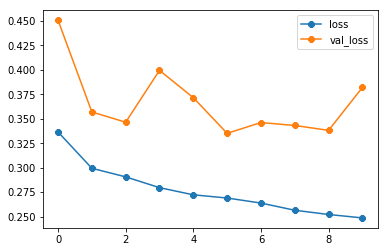

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.DataFrame({'loss':history.history['loss'],
             'val_loss':history.history['val_loss']})
df.plot(style='8-')